<a href="https://colab.research.google.com/github/csabiu/ML_tutorial/blob/master/DT_photoz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised Regression problem

In this notebook we will use decision tree and random forests algorihtms to learn a mapping between galaxy magnitudes and colors and the spectroscopic redshift.

We will construct some learning curves to determine the best choices of the algorihtms.

We will then use feature importance to understand which of the features give us the most predictive power, and then train a very simiple algorithm with reduced feature list.


# Load some libraries

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split
!pip install gdown

# Doanload the dataset

In [19]:
import gdown
!gdown https://drive.google.com/uc?id=1Wdy5-wnVFaRK-Xx3j4osQsMDoA6O9VeB

total 234M
6422547 drwxr-xr-x 1 root root 4.0K Jun  5 05:44  .
6291531 drwxr-xr-x 1 root root 4.0K Jun  5 05:15  ..
6291572 -rw-r--r-- 1 root root  72K Jun  5 05:24  1Wdy5-wnVFaRK-Xx3j4osQsMDoA6O9VeB
5111823 drwxr-xr-x 4 root root 4.0K Jun  1 13:40  .config
6291540 -rw-r--r-- 1 root root  66K Jun  5 05:16 'open?id=1Wdy5-wnVFaRK-Xx3j4osQsMDoA6O9VeB'
6291565 -rw-r--r-- 1 root root  66K Jun  5 05:17 'open?id=1Wdy5-wnVFaRK-Xx3j4osQsMDoA6O9VeB.1'
6291566 -rw-r--r-- 1 root root  65K Jun  5 05:24 'open?id=1Wdy5-wnVFaRK-Xx3j4osQsMDoA6O9VeB.2'
6291570 -rw-r--r-- 1 root root  65K Jun  5 05:24 'open?id=1Wdy5-wnVFaRK-Xx3j4osQsMDoA6O9VeB.3'
6422548 drwxr-xr-x 1 root root 4.0K Jun  1 13:40  sample_data
6291577 -rw-r--r-- 1 root root 233M Jun  5 05:44  SpecPhotodr14_hoyleb.csv.sampled.fits.bz2
6291568 -rw-r--r-- 1 root root  72K Jun  5 05:24 'view?usp=sharing'


# Clean the data

In [20]:
d = Table.read('SpecPhotodr14_hoyleb.csv.sampled.fits.bz2')
# will perform a bit of data cleaning.
d = d[d['SPEC_Z'] < 1.0]
d = d[d['SPEC_Z'] > 1e-3]

In [21]:
#you can look at the all the features available to you
# http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+PhotoObj+V
print (d.keys())

['OBJID', 'RA', 'DEC', 'PHOTPTYPE', 'PHOT_SG', 'FLAGS', 'SATURATED', 'BAD_COUNTS_ERROR', 'BINNED1', 'u', 'g', 'r', 'i', 'z', 'u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'MODELMAGERR_U', 'MODELMAGERR_G', 'MODELMAGERR_R', 'MODELMAGERR_I', 'MODELMAGERR_Z', 'EXTINCTION_U', 'EXTINCTION_G', 'EXTINCTION_R', 'EXTINCTION_I', 'EXTINCTION_Z', 'DERED_U', 'DERED_G', 'DERED_R', 'DERED_I', 'DERED_Z', 'PETRORAD_U', 'PETRORAD_G', 'PETRORAD_R', 'PETRORAD_I', 'PETRORAD_Z', 'PETRORADERR_U', 'PETRORADERR_G', 'PETRORADERR_R', 'PETRORADERR_I', 'PETRORADERR_Z', 'DEVRAD_U', 'DEVRADERR_U', 'DEVRAD_G', 'DEVRADERR_G', 'DEVRAD_R', 'DEVRADERR_R', 'DEVRAD_I', 'DEVRADERR_I', 'DEVRAD_Z', 'DEVRADERR_Z', 'DEVAB_U', 'DEVAB_G', 'DEVAB_R', 'DEVAB_I', 'DEVAB_Z', 'CMODELMAG_U', 'CMODELMAGERR_U', 'CMODELMAG_G', 'CMODELMAGERR_G', 'CMODELMAG_R', 'CMODELMAGERR_R', 'CMODELMAG_I', 'CMODELMAGERR_I', 'CMODELMAG_Z', 'CMODELMAGERR_Z', 'PSFMAG_U', 'PSFMAGERR_U', 'PSFMAG_G', 'PSFMAGERR_G', 'PSFMAG_R', 'PSFMAGERR_R', 'PSFMAG_I', 'PSFMAG

In [22]:
# we will use just dereddend magnitudes 
mags = ['DERED_U', 'DERED_G', 'DERED_R','DERED_I','DERED_Z']
d=d[d[mags[0]]!='null']
d=d[d[mags[1]]!='null']
d=d[d[mags[2]]!='null']
d=d[d[mags[3]]!='null']
d=d[d[mags[4]]!='null']

def f(x):
    return np.float(x)
f2 = np.vectorize(f)

#and color combinations created from them.
cols= []
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        cols.append(mags[i]+'-' + mags[j])

# let's load these into an input array
inputs = np.zeros((len(d), len(mags+cols)), dtype=float)
for i, key in enumerate(mags):
    inputs[:, i] = np.array(d[key])

cnt = len(mags)
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        inputs[:, cnt] = np.array(f2(d[mags[i]])) - np.array(f2(d[mags[j]]))
        cnt += 1


# for photo-z work
# The target/label values are spectroscopic redshifts

In [23]:
targets = np.array(f2(d['SPEC_Z']))

# we will split the data into a trainind and testing sample.


In [24]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.4, random_state=42)


In [25]:
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
    
#see https://scikit-learn.org/stable/modules/tree.html

#help(DT)

#let's train [.fit()]  a tree on the training sample, and then make predictions on the test sample

0.016351194791027087 0.01627702772254711


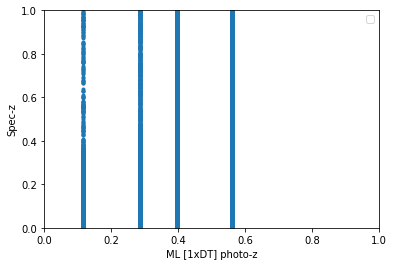

In [26]:
clf = DT(random_state=0, max_depth=2)
clf = clf.fit(x_train, y_train)

pred_train  = clf.predict(x_train)
pred_test = clf.predict(x_test)

mse_test = mean_squared_error(y_test, pred_test)
mse_train = mean_squared_error(y_train, pred_train)
plt.plot(pred_test,y_test, '.')#, label='test MSE={:0.2f}'.format(mse_test))
plt.legend()
plt.xlabel('ML [1xDT] photo-z')
plt.ylabel('Spec-z')
plt.xlim([0,1])
plt.ylim([0,1])

print mse_test, mse_train


# Show graph

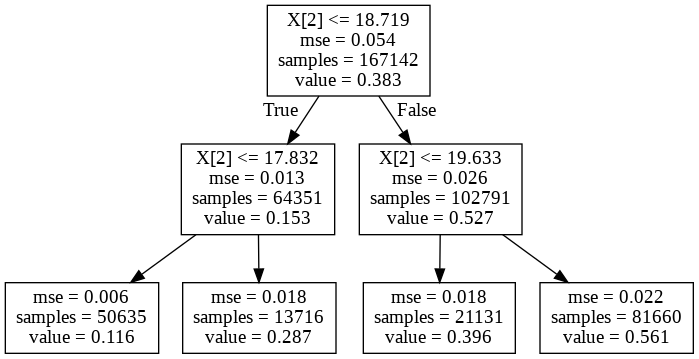

In [27]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data=export_graphviz(clf)

graph = pydotplus.graph_from_dot_data(dot_data)  

Image(graph.create_png())

# Lets increase the number of trees -> forest

In [29]:
#for regression [photo-z]
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

clf = RandomForestRegressor(max_depth=8,n_estimators=50)

0.008115858736437508 0.007400361927206489


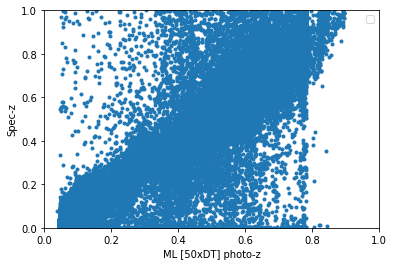

In [30]:
clf = clf.fit(x_train, y_train)

#replace None
pred_train  = clf.predict(x_train)
pred_test = clf.predict(x_test)

mse_test = mean_squared_error(y_test, pred_test)
mse_train = mean_squared_error(y_train, pred_train)
plt.plot(pred_test,y_test, '.')#, label='test MSE={:0.2f}'.format(mse_test))
plt.xlabel('ML [50xDT] photo-z')
plt.ylabel('Spec-z')
plt.xlim([0,1])
plt.ylim([0,1])

print mse_test, mse_train

(0, 1)

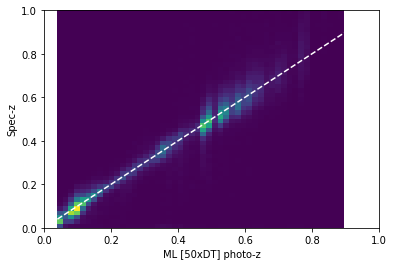

In [40]:
plt.hist2d(pred_test,y_test, bins=50)
plt.xlabel('ML [50xDT] photo-z')
plt.ylabel('Spec-z')
plt.plot([0,1],[0,1],'w--')
plt.xlim([0,1])
plt.ylim([0,1])

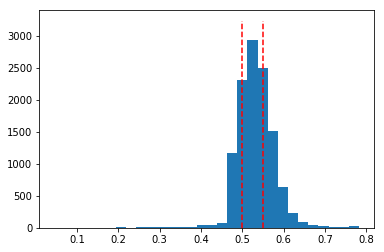

In [74]:
specz=[0.5,0.55]
a=plt.hist(pred_test[(y_test>specz[0]) & (y_test<specz[1])],30)
plt.plot([specz[0],specz[0]],[0,1.1*np.max(a[0])],'r--')
plt.plot([specz[1],specz[1]],[0,1.1*np.max(a[0])],'r--')